<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Подготовка" data-toc-modified-id="Подготовка-1">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li>
        <li>
            <span>
                <a href="#Обучение" data-toc-modified-id="Обучение-2">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li>
        <li>
            <span>
                <a href="#Выводы" data-toc-modified-id="Выводы-3">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>
        <li>
            <span>
                <a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li>
    </ul>
</div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Импорт и проверка данных

Для того, чтобы использовать библиотеки, которых нет в `jupyter notebook` нам нужно скачать их. Мы будем использовать для данной процедуры команду `pip install`, которая обращается напрямую к пакету `pip` из `python`, отвечающую за скачивание недостпуных библиотек 

In [1]:
# !pip install transformers
# !pip install torch
# !pip install lightgbm

Далее нам нужно просто импортировать их из `jupyter notebook` с помощью команды `from` и `import`. Для нашего проекта нам понадобятся:
- pandas - работа с данными 
- numpy - работа с математическими функции 
- torch - преобразование в тензоры (тензоры - данные для нейронных сетей)
- transformers - архитектура нейронных сетей, которые мы можем в дальнейшем использовать
- AutoTokenizer и AutoModel - токенайзер для создания токенов и модель для создания признаков для обучения модели
- f1_score - метрика f1 для получения и сравнивания результатов 
- plt и sns - создание графиков  
- train_test_split - работа с подготовкой данных 
- GridSearchCV - проверка работы модели с определенными параметрами
- LogisticRegression, SVC, LGBMClassifier - модель для предсказывания 
- StandardScaler - контролируем масштабность данных

In [2]:
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import AutoTokenizer, AutoModel
from sklearn.utils import shuffle
from tqdm import notebook
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

%matplotlib inline

После импорта нужных библиотек, мы можем сохранить данные в таблицу, с помощью pandas. Для проверки выведем пять строк нашей таблицы:

In [3]:
path = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'
data_tweets = pd.read_csv(path)
data_tweets.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Как видно, в нашей таблице всего два признака: text - запись твита, то, на чем мы будем обучать модель; toxic - токсичность текста (0 нормальный текст, 1 плохой текст). Далее предлагается проверить признаки на наличие пропусков и соответствие типам данных - используем метод `info()`

In [4]:
data_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Как видно из результата операции, все данные в пригодном для работы виде, однако давайте еще проверим таблицу методом `describe()` - увидим насколько верны максимальное, среднее и минимальное значения для таблицы

In [5]:
data_tweets.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Максимальное, среднее и минимальное значения в порядке, значит можно начинать анализировать таблицу и готовить ее к обучению модели. Однако давайте проверим уникальные значения тональности текста, вдруг там есть что-то, помимо 1 и 0. Также необходимо проверить пропуски на наличие пустот и пробелом.

In [6]:
data_tweets['toxic'].unique()

array([0, 1], dtype=int64)

In [7]:
data_tweets.query('toxic == "" or toxic == " "')

,text,toxic


## Работа с размерностью датасета и подготовка выборок

Далее мы проверим размерность классов и попробуем подобрать необходимые размеры для наших выборок. 

C:\Users\limit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'positive'), Text(1, 0, 'negative')]

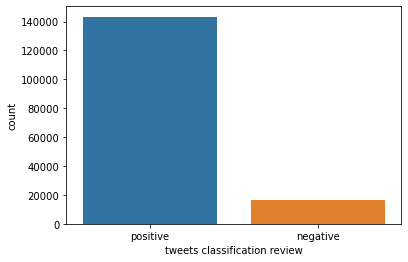

In [8]:
ax = sns.countplot(data_tweets.toxic)
plt.xlabel('tweets classification review')
ax.set_xticklabels(['positive', 'negative'])

In [9]:
balance_classes = np.round(np.bincount(data_tweets.toxic)[0]/np.bincount(data_tweets.toxic)[1],4)
print(f"Баланс классов в датасете такой, что на 1 негативный твит, приходится {balance_classes} твитов")

Баланс классов в датасете такой, что на 1 негативный твит, приходится 8.8349 твитов


Как видно, расслоение огромное, тут разница в 8.8 раз, что сильно сказалось бы на качестве модели, однако стоит отметить занимательный момент: каждый твит может выражать одну и ту же мысль совершенно разными словами. При удалении большого количества твитов есть возможность потерять близкие к уникальным сочетания слов, а это повлечет за собой менее уверенную в своих прогнозах модель. Поэтому мы ничего не будем делать с данным расслоением данных. 

Стоит отметить, что мы разобьем обучающую выборку на 2000 элементов, в целях ускорения работы программы. 

Для того, чтобы не потерять баланс классов мы применим функцию `stratify`, которая учтет разницу в классах наших данных. В качестве аргумента приведем признак, разница классов в котором мы хотим сохранить. 

In [10]:
data_train, data_valid = train_test_split(data_tweets, 
                                          test_size=0.01, 
                                          stratify=data_tweets.toxic,
                                          random_state=69)

print(data_train.shape, data_valid.shape)

(157975, 2) (1596, 2)


Раздление на выборки равно 99 к 1, так как обучающую выборку мы все равно поделим при помощи функции `sample`, а вот валидационную оставим в текущем состоянии, так мы сможем сохранить реальный баланс классов в выборке.

Для проверки лучше всего проверить количество элементов в выборках и их разброс в классах.

C:\Users\limit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'positive'), Text(1, 0, 'negative')]

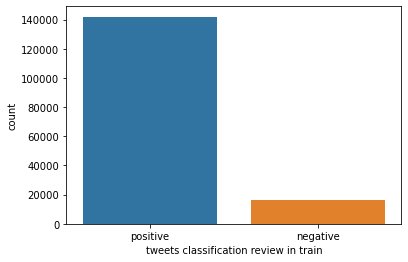

In [11]:
ax = sns.countplot(data_train.toxic)
plt.xlabel('tweets classification review in train')
ax.set_xticklabels(['positive', 'negative'])

C:\Users\limit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'positive'), Text(1, 0, 'negative')]

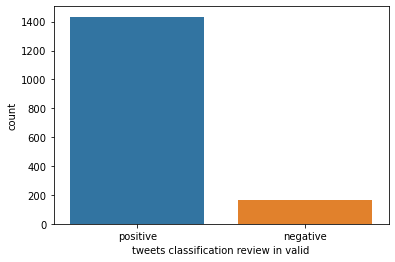

In [12]:
ax_1 = sns.countplot(data_valid.toxic)
plt.xlabel('tweets classification review in valid')
ax_1.set_xticklabels(['positive', 'negative'])

In [13]:
balance_classes_train = np.round(np.bincount(data_train.toxic)[0]/np.bincount(data_train.toxic)[1],4)
balance_classes_valid = np.round(np.bincount(data_valid.toxic)[0]/np.bincount(data_valid.toxic)[1],4)

print(f"Количество строк в toxic_train по классам: {np.bincount(data_train.toxic)}")
print(f"Количество строк в toxic_valid по классам: {np.bincount(data_valid.toxic)}")
print(f"На 1 негативный твит в обучающей выборке приходится {balance_classes_train} твитов")
print(f"На 1 негативный твит в валидационной выборке приходится {balance_classes_valid} твитов")

Количество строк в toxic_train по классам: [141912  16063]
Количество строк в toxic_valid по классам: [1434  162]
На 1 негативный твит в обучающей выборке приходится 8.8347 твитов
На 1 негативный твит в валидационной выборке приходится 8.8519 твитов


Как видно, баланс классов такой же, как и у изначальной выборке, а это значит, что деление данных при помощи метода train_test_split с применением функции stratify удачно прошло. 

Пришло время делить обучающую выборку на сокращенную выборку, в которой будет 2000 объектов, твитов. Применяем функцию sample с аргументом random_state, ведь с данным аргументом подвыборка сохранит похожий на весь датасет баланс классов

In [14]:
data_sampled_train_poss = data_train.query('toxic == 0').sample(1434, random_state=69).reset_index(drop=True)
data_sampled_train_neg = data_train.query('toxic == 1').sample(162, random_state=69).reset_index(drop=True)

data_sampled_train = shuffle(pd.concat([data_sampled_train_poss,data_sampled_train_neg])).reset_index(drop=True)
balance_classes_train_sampled = np.round(np.bincount(data_sampled_train.toxic)[0]/np.bincount(data_sampled_train.toxic)[1],4)
print(f"На 1 негативный твит в обучающей разделенной выборке приходится {balance_classes_train_sampled} твитов")

На 1 негативный твит в обучающей разделенной выборке приходится 8.8519 твитов


Последний шаг - разбить данные на features - признаки, на которых мы будем обучаться и target - целевой признак, который будет учить наши модели, к какому результату стремиться

In [15]:
target_train = data_sampled_train['toxic']
target_valid = data_valid['toxic']

text_train = data_sampled_train.drop('toxic', axis=1)
text_valid = data_valid.drop('toxic', axis=1)


Данные поделены на выборки, соблюдены балансы классов и мы готовы к обучению модели. Стоит сразу отметить, что мы будем преобразовывать все данные, то есть и обучающую и валидационные выборки, а это значит, что тот код, который будет дублироваться мы будем оборачивать в функции. 

## Обучение BERT

Вот мы и приступаем к обучению. Первым делом нам надо импортировать и сохранить нашу BERT модель и токенайзер. Для этого воспользуемся методами с библиотеки transformers: AutoTokenizer и BertModel. В качестве аргумента указываем откуда брать данные для модели и токенайзера. В качестве предобученной модели мы будем брать `distilbert`, которая гораздо легче и быстрее стандартной `BERT`, что нам и послужит хорошей монетой, ведь на данный момент нам нужна скорость. 

In [16]:
model_class, tokenizer, pretrained_weights = (
    transformers.DistilBertModel,
    transformers.DistilBertTokenizer,
    "distilbert-base-uncased"
)

tokenizer = tokenizer.from_pretrained(pretrained_weights)

model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Модели импортированы, теперь займемся тектом, ведь модель не понимает его так, как человек, для нее надо перевести текст в числовой формат, который она может обрабатывать и делать на их основании предсказания. Для этого первым делом поймем, насколько длинные у нас есть твиты: твиты закидываем в токенайзер, каждый символ считаем как токен и получаем максимальную длину токена. Все длины твитов сохраняем в списке, который в дальнейшем проицируем в графике

In [17]:
def tokens_length(data):
    token_lens = []
    for txt in data.values:
        tokens = tokenizer.encode(str(txt), max_length=1024, truncation=True)
        token_lens.append(len(tokens))
    return token_lens

In [18]:
token_lens_train = tokens_length(text_train)
token_lens_valid = tokens_length(text_valid)

C:\Users\limit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


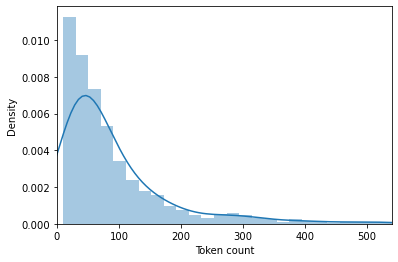

In [19]:
sns.distplot(token_lens_train)
plt.xlim([0, 540]);
plt.xlabel('Token count');

C:\Users\limit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


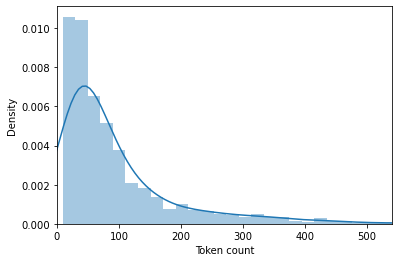

In [20]:
sns.distplot(token_lens_valid)
plt.xlim([0, 540]);
plt.xlabel('Token count');

Как видно, в основном длина колеблется на уровне 90-100 токенов, но максимальное значение равняется 500 (дальше почти ничего нет). Значение 500 запоминаем и идем дальше - создаем токенизированный список данных, где все токены будут иметь длину 500, с добавлением спецаильный токенов: символы пунктуации, начало и конец. Без такого процесса наша модель просто не сможет запуститься, ведь длина токенов на одинакова. Также создадим предупреждающую маску, которая будет хранить в себе данные 1 и 0, по длине токенов, где 1 - естественная длина, 0 - длина, заполненная для достижения максимальной длины 

In [21]:
def tokenize_text(data):
    tokenized = [tokenizer.encode(str(x), add_special_tokens=True, max_length = 512, truncation=True) for x in data.values]
    return tokenized

def do_padded_attention_mask(tokenized_text):
    max_len = 0
    for i in tokenized_text:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized_text])
    attention_mask = np.where(padded != 0, 1, 0)
    
    return padded, attention_mask

In [22]:
tokenized_train = tokenize_text(text_train)
padded_train, attention_mask_train = do_padded_attention_mask(tokenized_train)

tokenized_valid = tokenize_text(text_valid)
padded_valid, attention_mask_valid = do_padded_attention_mask(tokenized_valid)

print(padded_train.shape, padded_valid.shape)

(1596, 512) (1596, 512)


токенизированный текст готов, как и предупреждающая маска, а значит мы можем приступить к созданию функции BERT_work, которая будет находить вложения по преобразованному тексту и предупреждающей маске. Все это мы будем делать с помощью деления нашей таблицы на части по n количество токенов в каждой связке (все зависит от того, сколько элементов у нас поступает на обучение в padded и attention_mask) и чтобы все данные были учтены, мы делим нашу выборку на батчи равных частей, на которое можно поделить количество элементов в выборке, которые мы потом преобразуем в тензоры (тензоры - специальные данные, которые записываются в виде матрицы, удобной для чтения модели понимания текста). Далее мы обучаем эти данные в модели и сохраняем результат, который в дальнейшем отправим на обучение нашим алгоритмам.

In [23]:
def BERT_work(padded, attention_mask, batch_size):
    embeddings = []
    model.cpu()

    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cpu() 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cpu()

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())
            
    return embeddings

In [24]:
embeddings_train = BERT_work(padded_train, attention_mask_train, 12)
embeddings_valid = BERT_work(padded_valid, attention_mask_valid, 12)

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

## Создание выборок для алгоритмов ML и обучение алгоритмов

После долгого выполнения преобразования текста в удобный для алгоритма машинного обучения вид, мы можем создать переменные для признаков, которые в дальнейшем будут обучать наши алгоритмы (целевые признаки возьмем из пункта 1)

In [25]:
features_train = np.concatenate(embeddings_train)
features_valid = np.concatenate(embeddings_valid)
print(features_train.shape, features_valid.shape)

(1596, 768) (1596, 768)


Поняв, что размер признаков верен, мы запускаем наши ранее импортированные алгоритмы и проверяем результаты метрикой f1_score. Логика проверки состоит в том, чтобы понять, как часто наша модель ошибается при прогнозе позитивности и негативности твитов, ведь в формуле используются следующие значения: точность предсказания и доля предсказаний.

Также, во многих моделях классификации реализован механизм учета дисбаланса классов, что нам и понадобится, ведь разница между количеством положительных и отрицательных твитов равняется 8.6 к 1. Для того, чтобы учесть данный дисбаланс, мы создадим словарь внутри нашего random_search, который будет переберать в себе веса для элемента токсичности текста.


Для проверки наиболее подходящих гиперпараметров попробуем запустить метод `RandomizedSearchCV`, который пройдется по ним - `param_grid`. `cv` - сколько тестов сделать по модели, с разбиением всей выборки на определенное количество частей, каждая из которых станет валидационной для проверки. Также стоит отметить, что мы будем проверять качество в `RandomizedSearchCV` по метрике `f1_score`. После прогона гиперпараметров, мы запомним модель, с лучшими гиперпараметрами и будем получать предсказания уже с этой модели. Лучший результат и лучшую модель мы вернем 

In [26]:
def select_best_model_res(params, model, x_train, x_test, y_train, y_test):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = RandomizedSearchCV(model, params, 
                              n_iter=1, scoring='f1_macro', cv=cv, random_state=69)
    grid.fit(x_train, y_train)
    best_grid = grid.best_estimator_
    
    predictions_best_grid = best_grid.predict(x_test)
    
    return f1_score(y_test, predictions_best_grid, average='macro'), best_grid

In [27]:
random_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [i for i in range(100, 1000)],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 4}]
    }

model_log_reg = LogisticRegression(random_state=49)
log_reg_score, log_reg_best_grid = select_best_model_res(random_grid_lr, model_log_reg, features_train, features_valid, target_train, target_valid)

print(log_reg_score, log_reg_best_grid)

0.7904592179348107 LogisticRegression(C=10, class_weight={0: 1, 1: 3}, max_iter=941,
                   random_state=49)


Как выяснилось, наилучшим вариантов являются: `C` = 10, веса = 1 и 3 соответственно, максимальное количество итераций = 941. Результат равен 79 процентам, что лучше того, сколько нам дали для порога - 75, но давайте проверим другие модели: SVC и градиентный бустинг

In [28]:
model_svc = SVC(random_state=69)

random_grid_svc = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [i for i in range(100, 1000)],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 4}]
    }

svc_score, svc_best_grid = select_best_model_res(random_grid_svc, model_svc, features_train, features_valid, target_train, target_valid)

print(svc_score, svc_best_grid)

0.8085329330192255 SVC(C=10, class_weight={0: 1, 1: 3}, kernel='sigmoid', max_iter=766,
    random_state=69)


C:\Users\limit\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=766).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'



Самая результативная модель получилась с такими гиперпараметрами: С = 10, веса = 1 и 3, ядро = сигмоида и максимальное количество итераций = 756. Результат на данной модели выше 81, что довольно лучше логистической регрессии. Последняя модель - градиентный бустинг:

In [29]:
model_lgbm = LGBMClassifier(random_state=69)

random_grid_lgbm = {
    'n_estimators': [i for i in range(30, 150, 5)],
    'max_depth': [i for i in range(5, 15)],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 4}]
    }

lgbm_score, lgbm_best_grid = select_best_model_res(random_grid_lgbm, model_lgbm, features_train, features_valid, target_train, target_valid)

print(lgbm_score, lgbm_best_grid)

0.7738902298247455 LGBMClassifier(class_weight={0: 1, 1: 3}, learning_rate=1.0, max_depth=13,
               n_estimators=75, random_state=69)



К сожалению результат не самый лучший: веса = 1 и 3, скорость обучения = 1, максимальная глубина = 13, а количество деревьев = 75. Результат равен 77.4, что хуже логистической на 1.6 процента

## Выводы

В заключении работы хочу сказать, что преобразование текста с помощью `BERT` гораздо точнее, также требуется гораздо меньше данных, ведь нейросеть уже предварительно обучена, поэтому нам требуется не весь датасет, а лишь некоторая его часть. Разделение на токены и предупреждающую маску происходят благодаря токенайзера нашей модели - `BERT_tokenizer`. Получение тензоров для дальнейшего обучения получаются благодаря нашей модели `BERT_model`, который в качестве данных берет части выборки - batch, размер которых мы регулируем. Дальнейшее обучение происходит благодаря трем алгоритмам: логистическая регессия, svc и градиентный бустинг. Улучшение данных моделей показало, что лучшей моделью является модель SVC, которая дет  результат = 81% качества, что лучше логистической регрессии, с результатом 79% и алгоритма градиентного бустинга, который дает результат равный 77.4%. В итоге для бизнеса лучше всего выбрать модель SVC.

Короткий экскурс по тому, что было сделано в нашем проекте:
- данные получены и сохранены в переменной data_tweets
- таблица проверена на наличие ошибок и неточностей
- проверена размерность положительных и отрицательных твитов
- подготовлена размеренная выборка для обучения нейросети
- тексты поделены на токены и на их основе создана маска предупреждения 
- получены тензоры для дальнейшего обучения нашей логистической регрессии
- обучены модели
- выбрана модель SVC, так как дает самый лучший результат